In [2]:
import functions as mf
import functions_axis_symmetric as mfa
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
import scipy.sparse.linalg as la
from scipy.special import lambertw

import importlib
importlib.reload(mf)
importlib.reload(mfa)

<module 'functions_axis_symmetric' from 'c:\\Users\\brent\\Documents\\comp_multphase_flow\\functions_axis_symmetric.py'>

In [3]:
rho_plasma = 1003 #  kg/m3
mu_plasma = 1e-3 # kg/ms

rho_RBC = 1096 # kg/m3
diameter_RBC = 8e-6 # m
volume_fraction_RBC = 0.1

Ny = 1000
y_end = 5e-3 # m

angle = 0#np.pi / 2

boundary_condition = [1, 1] 
blood_flow_rate = 20e-3 # m/s  # moet gecheckt worden
Q_des = 185*1e-6 #m3/s total bloodflow
pressure_difference = 1e-3
pressure_boundary = np.array([1, 1])*1e-3
system = mf.Multiflow(Ny, y_end, rho_plasma, pressure_difference,
                      pressure_boundary, boundary_condition, mu_plasma, angle)
# mu = system.calc_mu(mu_plasma)


def reloadsystem():
    importlib.reload(mf)
    system = mf.Multiflow(Ny, y_end, rho_plasma, pressure_difference,
                      pressure_boundary, boundary_condition, mu_plasma, angle)
    return system

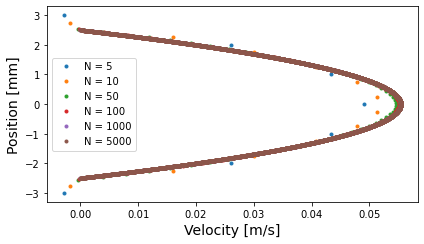

In [4]:
def reloadsystem():
    importlib.reload(mf)
    system = mf.Multiflow(Ny, y_end, rho_plasma, pressure_difference,
        pressure_boundary, boundary_condition, mu_plasma, angle)
    return system         

#4 Prescribed flow rate
Ny = 1000
N_range = [5, 10, 50, 100, 1000, 5000]
# N_range = [1000, 5000, 20000]
plt.figure(figsize=(6,3.5))

for Ny in N_range:
    rho_plasma = 1003 #  kg/m3
    mu_plasma = 1e-3 # kg/ms

    rho_RBC = 1096 # kg/m3
    diameter_RBC = 8e-6 # m
    volume_fraction_RBC = 0.1

    y_end = 5e-3 # m

    angle = np.pi / 2

    boundary_condition = [1, 1] 
    blood_flow_rate = 20e-3 # m/s  # moet gecheckt worden
    Q_des = 185*1e-6 #m3/s total bloodflow
    pressure_difference = 1e-3
    pressure_boundary = np.array([1, 1])*1e-3
    system = mf.Multiflow(Ny, y_end, rho_plasma, pressure_difference,
                        pressure_boundary, boundary_condition, mu_plasma, angle)
    mu = system.calc_mu(mu_plasma)

    system = reloadsystem()
    # Q_des = np.pi * (system.y_end/2)**2 * blood_flow_rate
    eps = 1e-3
    error = 1
    system.set_pressure_difference(pressure_difference)

    velocity = system.simulate(mu)
    Q = np.trapz(velocity, x=system.y)
    factor = 0.95
    #P = [system.pressure_difference, 2*system.pressure_difference]
    switch = [0,0]

    while error > eps:
    # for i in range(1):
        if switch[-2] != switch[-1]:
            factor*=0.9
        if Q<Q_des:
            # system.pressure_difference = P[-1] + np.abs(P[-1]-P[-2])/2 * factor
            system.pressure_difference += system.pressure_difference * factor

            velocity = system.simulate(mu)
            Q = np.trapz(velocity, x=system.y)
            error = np.abs((Q-Q_des)/Q_des)
            switch.append(0)
            # P.append(system.pressure_difference)
        else:
            # system.pressure_difference = P[-1] - np.abs(P[-1]-P[-2])/2 * fac
            system.pressure_difference -= system.pressure_difference * factor
            velocity = system.simulate(mu)
            Q = np.trapz(velocity, x=system.y)
            error = np.abs((Q-Q_des)/Q_des)
            # P.append(system.pressure_difference)
            switch.append(1)
        if len(switch) == 3000:
            print("Oh nyo, it's bwoken")
            break
    velocity_laminar = velocity
    mu_laminar = mu

    plt.plot(velocity, system.y * 1e3,  ".", label= 'N = {}'.format(Ny))

plt.xlabel("Velocity [m/s]", fontsize=14)
plt.ylabel("Position [mm]", fontsize=14)
plt.legend(fontsize=10)
plt.tight_layout()
# plt.savefig("Images/Laminar.svg")
plt.show()

53
0.00018491037999106798 0.000185


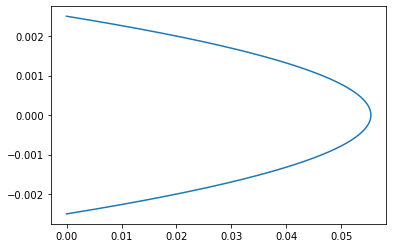

In [5]:
# Prescribed flow rate
Ny = 1000
system = reloadsystem()
mu = system.calc_mu(mu_plasma)
# Q_des = np.pi * (system.y_end/2)**2 * blood_flow_rate
eps = 1e-3
error = 1
system.set_pressure_difference(pressure_difference)

velocity = system.simulate(mu)
Q = np.trapz(velocity, x=system.y)
factor = 0.95
#P = [system.pressure_difference, 2*system.pressure_difference]
switch = [0,0]

while error > eps:
# for i in range(1):
    if switch[-2] != switch[-1]:
        factor*=0.9
    if Q<Q_des:
        # system.pressure_difference = P[-1] + np.abs(P[-1]-P[-2])/2 * factor
        system.pressure_difference += system.pressure_difference * factor

        velocity = system.simulate(mu)
        Q = np.trapz(velocity, x=system.y)
        error = np.abs((Q-Q_des)/Q_des)
        switch.append(0)
        # P.append(system.pressure_difference)
    else:
        # system.pressure_difference = P[-1] - np.abs(P[-1]-P[-2])/2 * fac
        system.pressure_difference -= system.pressure_difference * factor
        velocity = system.simulate(mu)
        Q = np.trapz(velocity, x=system.y)
        error = np.abs((Q-Q_des)/Q_des)
        # P.append(system.pressure_difference)
        switch.append(1)
    if len(switch) == 300:
        print("Oh nyo, it's bwoken")
        break

velocity_laminar = velocity
mu_laminar = mu

print(len(switch))
plt.plot(velocity, system.y)
print(Q, Q_des)

## Brentl Mixing Length

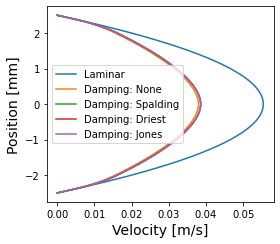

In [6]:


argument_types = [None, 'Spalding', 'Driest', 'Jones']

velocity_new = velocity_laminar

plt.figure(figsize=(4,3.5))
plt.plot(velocity_laminar, system.y * 1e3, label="Laminar")

for argument_type in argument_types:
    # Then calculate the solution with Prandtl mixing length
    eps = 0.01
    error = 1
    i = 0

    # Looping till solution converges
    while error > eps:
        velocity = velocity_new

        # Calculate new effective viscosity
        mu_Prandtl = system.calc_mu_Prandtl(velocity, argument_type)

        # Calculate ensuing velocity
        velocity_new = system.simulate(mu_Prandtl)

        error = np.sum(np.abs((velocity_new - velocity) / velocity))
        i+=1
        print("iteration", i, "with error", error, end='\r')

        if i > 2000:
            print("Oh nyo, it's bwoken")
            break

    velocity_turbulent = velocity_new
    mu_turbulent = mu_Prandtl

    
    plt.plot(velocity_turbulent, system.y * 1e3, label="Damping: {}".format(argument_type))



plt.xlabel('Velocity [m/s]', fontsize=14)
plt.ylabel('Position [mm]', fontsize=14)
plt.legend(fontsize=10)
plt.tight_layout()
plt.savefig("Images/Prandt_Mixing_lengths.svg")

plt.show()

# # Check for log region
# plt.plot(system.y + system.y_end / 2, velocity_laminar)
# plt.plot(system.y + system.y_end / 2, velocity_turbulent)
# plt.xscale("log")

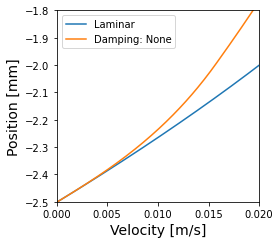

In [7]:


argument_types = [None]

velocity_new = velocity_laminar

plt.figure(figsize=(4,3.5))
plt.plot(velocity_laminar, system.y*1e3, label="Laminar")

for argument_type in argument_types:
    # Then calculate the solution with Prandtl mixing length
    eps = 0.01
    error = 1
    i = 0

    # Looping till solution converges
    while error > eps:
        velocity = velocity_new

        # Calculate new effective viscosity
        mu_Prandtl = system.calc_mu_Prandtl(velocity, argument_type)

        # Calculate ensuing velocity
        velocity_new = system.simulate(mu_Prandtl)

        error = np.sum(np.abs((velocity_new - velocity) / velocity))
        i+=1
        print("iteration", i, "with error", error, end='\r')

        if i > 2000:
            print("Oh nyo, it's bwoken")
            break

    velocity_turbulent = velocity_new
    mu_turbulent = mu_Prandtl

    
    plt.plot(velocity_turbulent, system.y*1e3, label="Damping: {}".format(argument_type))



plt.xlabel('Velocity [m/s]', fontsize=14)
plt.ylabel('Position [mm]', fontsize=14)
plt.xlim(0,0.02)
plt.ylim(-2.5,-1.8 )
# plt.xlim(0.035, 0.04)
plt.legend(fontsize=10)
plt.tight_layout()

# plt.savefig("Images/Prandt_Mixing_lengths_zoom.svg")
plt.show()

# # Check for log region
# plt.plot(system.y + system.y_end / 2, velocity_laminar)
# plt.plot(system.y + system.y_end / 2, velocity_turbulent)
# plt.xscale("log")

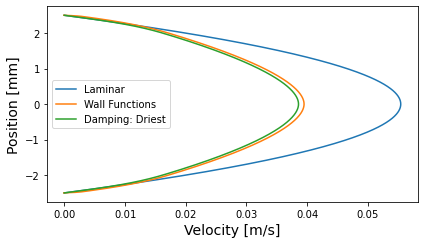

In [8]:
argument_type = "Driest"

velocity_new = velocity_laminar

# Then calculate the solution with Prandtl mixing length
eps = 0.01
error = 1
i = 0

# Looping till solution converges
while error > eps:
    velocity = velocity_new

    # Calculate new effective viscosity
    mu_Prandtl = system.calc_mu_Prandtl(velocity, argument_type)

    # Calculate ensuing velocity
    velocity_new = system.simulate(mu_Prandtl)

    error = np.sum(np.abs((velocity_new - velocity) / velocity))
    i+=1
    # print("iteration", i, "with error", error, end='\r')

    if i > 2000:
        print("Oh nyo, it's bwoken")
        break

velocity_Driest = velocity_new
mu_Driest = mu_Prandtl


# # Check for log region
# plt.plot(system.y + system.y_end / 2, velocity_laminar)
# plt.plot(system.y + system.y_end / 2, velocity_Driest)
# plt.xscale("log")


# Wall Function Constants 
velocity_new = velocity_turbulent
E = 9.8
kappa = 0.41
ks = 10 * system.nu_0

i = 0
error = 1
epsilon = 1e-5
while error > epsilon:
    velocity = velocity_new

    # Calculate the new y_plus
    tau_wall = velocity[1] / system.y_wall[1]
    u_tau = np.sqrt(tau_wall / system.rho)
    nu_0 = (mu_turbulent / system.rho)
    y_plus = system.y_wall * u_tau / nu_0

    # Calculate new wall roughness
    ks_plus = u_tau * ks / nu_0[1]
    wall_roughness = 32.6 / ks_plus

    
    # Add new nu for at wall
    nu_plus = np.zeros(system.Ny+2)
    mask = (y_plus < 11.25) * (y_plus > 0)
    nu_plus[mask] = nu_0[mask] * (y_plus[mask] * kappa / np.log(E * y_plus[mask]) - 1)
    nu = nu_0 + nu_plus
    mu = nu * system.rho

    # Calculate new velocity
    velocity_new = system.simulate(mu)

    # Error difference in old and new velocity
    error = np.sum(np.abs((velocity_new - velocity) / velocity))
    i+=1
    # print("iteration", i, "with error", error, end='\r')

    if i > 200:
        print("Oh nyo, it's bwoken")
        break

plt.figure(figsize=(6,3.5))

# print("iteration", i, "with error", error, end='\n')
plt.plot(velocity_laminar, system.y*1e3, label='Laminar')
plt.plot(velocity_new, system.y*1e3, label="Wall Functions")
plt.plot(velocity_Driest, system.y*1e3, label="Damping: Driest")

plt.xlabel('Velocity [m/s]', fontsize=14)
plt.ylabel('Position [mm]', fontsize=14)
plt.legend(fontsize=10)
plt.tight_layout()
plt.savefig("Images/Wall_Functions_vs_Prandtl.svg")

plt.legend()
plt.show()

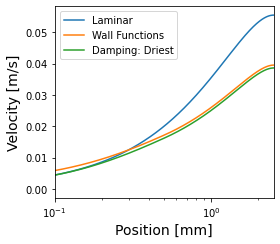

In [9]:
plt.figure(figsize=(4,3.5))

# print("iteration", i, "with error", error, end='\n')
plt.plot(system.y*1e3 + 2.5 + system.dy, velocity_laminar, label='Laminar')
plt.plot(system.y*1e3 + 2.5+ system.dy, velocity_new, label="Wall Functions")
plt.plot(system.y*1e3 + 2.5+ system.dy, velocity_Driest, label="Damping: Driest")
plt.xscale("log")

plt.ylabel('Velocity [m/s]', fontsize=14)
plt.xlabel('Position [mm]', fontsize=14)
plt.xlim(1e-1, 2.5)
plt.legend(fontsize=10)
plt.tight_layout()
plt.savefig("Images/Wall_Functions_vs_Prandtl_Loglaw.svg")

plt.show()

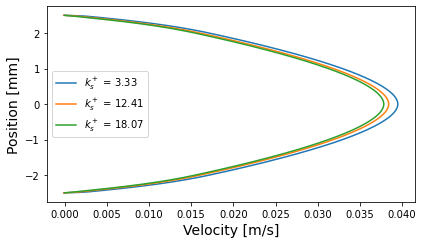

In [10]:
velocity_new = velocity_turbulent
E = 9.8
kappa = 0.41
kss = np.array([ 10, 40, 75]) * system.nu_0
plt.figure(figsize=(6,3.5))

for ks in kss:

    i = 0
    error = 1
    epsilon = 1e-5
    while error > epsilon:
        velocity = velocity_new

        # Calculate the new y_plus
        tau_wall = velocity[1] / system.y_wall[1]
        u_tau = np.sqrt(tau_wall / system.rho)
        nu_0 = (mu_turbulent / system.rho)
        y_plus = system.y_wall * u_tau / nu_0

        # Calculate new wall roughness
        ks_plus = u_tau * ks / nu_0[1]
        wall_roughness = 32.6 / ks_plus

        
        # Add new nu for at wall
        nu_plus = np.zeros(system.Ny+2)
        mask = (y_plus < 11.25) * (y_plus > 0)
        nu_plus[mask] = nu_0[mask] * (y_plus[mask] * kappa / np.log(wall_roughness * y_plus[mask]) - 1)
        nu = nu_0 + nu_plus
        mu = nu * system.rho

        # Calculate new velocity
        velocity_new = system.simulate(mu)

        # Error difference in old and new velocity
        error = np.sum(np.abs((velocity_new - velocity) / velocity))
        i+=1
        # print("iteration", i, "with error", error, end='\r')

        if i > 200:
            print("Oh nyo, it's bwoken")
            break
    ks_plus = ks_plus.round(2)
    plt.plot(velocity_new, system.y*1e3, label=r'$k_s^+$ = {}'.format(ks_plus))

plt.xlabel('Velocity [m/s]', fontsize=14)
plt.ylabel('Position [mm]', fontsize=14)
plt.legend(fontsize=10)
plt.tight_layout()
plt.savefig("Images/Wall_Roughness.svg")

plt.show()

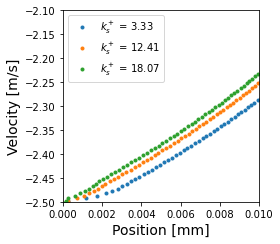

In [11]:
velocity_new = velocity_turbulent
E = 9.8
kappa = 0.41
kss = np.array([ 10, 40, 75]) * system.nu_0
plt.figure(figsize=(4,3.5))

for ks in kss:

    i = 0
    error = 1
    epsilon = 1e-5
    while error > epsilon:
        velocity = velocity_new

        # Calculate the new y_plus
        tau_wall = velocity[1] / system.y_wall[1]
        u_tau = np.sqrt(tau_wall / system.rho)
        nu_0 = (mu_turbulent / system.rho)
        y_plus = system.y_wall * u_tau / nu_0

        # Calculate new wall roughness
        ks_plus = u_tau * ks / nu_0[1]
        wall_roughness = 32.6 / ks_plus

        
        # Add new nu for at wall
        nu_plus = np.zeros(system.Ny+2)
        mask = (y_plus < 11.25) * (y_plus > 0)
        nu_plus[mask] = nu_0[mask] * (y_plus[mask] * kappa / np.log(wall_roughness * y_plus[mask]) - 1)
        nu = nu_0 + nu_plus
        mu = nu * system.rho

        # Calculate new velocity
        velocity_new = system.simulate(mu)

        # Error difference in old and new velocity
        error = np.sum(np.abs((velocity_new - velocity) / velocity))
        i+=1
        # print("iteration", i, "with error", error, end='\r')

        if i > 200:
            print("Oh nyo, it's bwoken")
            break
    ks_plus = ks_plus.round(2)
    plt.plot(velocity_new, system.y*1e3,".", label=r'$k_s^+$ = {}'.format(ks_plus))

plt.ylabel('Velocity [m/s]', fontsize=14)
plt.xlabel('Position [mm]', fontsize=14)
plt.legend(fontsize=10)
plt.xlim(0,0.01)
plt.ylim(-2.5,-2.1 )
plt.tight_layout()
plt.savefig("Images/Wall_Roughness_zoomin.svg")

plt.show()

c:\Users\brent\Documents\comp_multphase_flow\functions.py:323: RuntimeWarning: divide by zero encountered in true_divide
  velocity_particles_new = velocity_plasma[1:-1] - (1 / (18 * alpha_particles[1:-1] * f_particle * self.nu_0 / self.particle_D**2)) * \
c:\Users\brent\Documents\comp_multphase_flow\functions.py:323: RuntimeWarning: invalid value encountered in multiply
  velocity_particles_new = velocity_plasma[1:-1] - (1 / (18 * alpha_particles[1:-1] * f_particle * self.nu_0 / self.particle_D**2)) * \


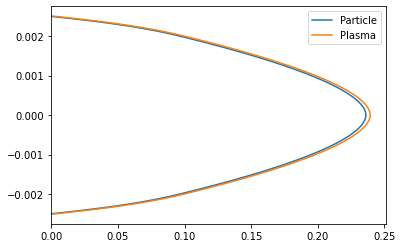

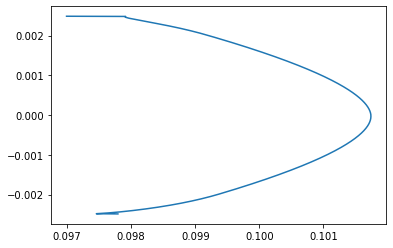

In [12]:
# Add particles to the system
system = reloadsystem()
system.add_particles(rho_RBC, diameter_RBC, volume_fraction_RBC)


# Wall Function Constants 
velocity_new = velocity_turbulent
E = 9.8
kappa = 0.41
ks = 10 * system.nu_0

i = 0
error = 1
epsilon = 1e-5
while error > epsilon:
    velocity = velocity_new

    # Calculate the new y_plus
    tau_wall = velocity[1] / system.y_wall[1]
    u_tau = np.sqrt(tau_wall / system.rho)
    nu_0 = (mu_turbulent / system.rho)
    y_plus = system.y_wall * u_tau / nu_0

    # Calculate new wall roughness
    ks_plus = u_tau * ks / nu_0[1]
    wall_roughness = 32.6 / ks_plus

    
    # Add new nu for at wall
    nu_plus = np.zeros(system.Ny+2)
    mask = (y_plus < 11.25) * (y_plus > 0)
    nu_plus[mask] = nu_0[mask] * (y_plus[mask] * kappa / np.log(wall_roughness * y_plus[mask]) - 1)
    nu = nu_0 + nu_plus
    mu = nu * system.rho

    # Calculate new velocity
    velocity_new = system.simulate(mu)

    # Error difference in old and new velocity
    error = np.sum(np.abs((velocity_new - velocity) / velocity))
    i+=1
    # print("iteration", i, "with error", error, end='\r')

    if i > 200:
        print("Oh nyo, it's bwoken")
        break



velocity_turbulent = velocity_new
mu_turbulent = mu

# Add particles to the system
system = reloadsystem()
system.add_particles(rho_RBC, diameter_RBC, volume_fraction_RBC)


# calculate initial alpha of the particles
alpha_particles = system.calc_alpha(velocity_turbulent, mu_turbulent)

# Calculate volumetric plasma concentration
alpha_fluid = 1 - alpha_particles
velocity_new = velocity_turbulent

# While loop to iterate of velocity
i = 0
error = 1
epsilon = 1e-3
while error > epsilon:
    velocity = velocity_new

    # Calculate new velocity
    velocity_new = system.simulate_with_particles(mu_turbulent, alpha_fluid)

    # Error difference in old and new velocity
    error = np.sum(np.abs((velocity_new - velocity) / velocity))
    alpha_particles = system.calc_alpha(velocity_turbulent, mu_turbulent)

    # Calculate volumetric plasma concentration
    alpha_fluid = 1 - alpha_particles
    i+=1

    if i > 200:
        print("Oh nyo, it's bwoken")
        break


velocity_plasma = velocity_new
# alpha_particles = np.linspace(0.05, 0.15, Ny+2) * 10
# alpha_particles = np.ones(Ny+2) * 0.9
velocity_plasma = system.simulate_with_particles(mu_turbulent, 1-alpha_particles)

velocity_particle = system.solve_particle_velocity(alpha_particles, velocity_plasma, mu_turbulent)

plt.plot(velocity_particle, system.y[1:-1],label="Particle")
plt.plot(velocity_plasma[1:-1], system.y[1:-1], label="Plasma")
plt.xlim(0)
plt.legend()
plt.show()
# alpha_particles[alpha_particles != 0] = np.abs(alpha_particles[alpha_particles != 0] -0.1)
plt.plot(alpha_particles[alpha_particles != 0], system.y[alpha_particles != 0])
plt.show()

In [135]:
rho_plasma = 1003 #  kg/m3
mu_plasma = 1e-3 # kg/ms

rho_RBC = 2500 # kg/m3
diameter_RBC = 8e-6 # m
volume_fraction_RBC = 0.45

y_end = 5e-3 # m
Ny = 1000
angle = np.pi / 4

boundary_condition = [1, 1] 
blood_flow_rate = 20e-3 # m/s  # moet gecheckt worden
Q_des = 185*1e-6 #m3/s total bloodflow
pressure_difference = 1e-3
pressure_boundary = np.array([1, 1])*1e-3
system = mf.Multiflow(Ny, y_end, rho_plasma, pressure_difference,
                      pressure_boundary, boundary_condition, mu_plasma, angle)
mu = system.calc_mu(mu_plasma)


def reloadsystem():
    importlib.reload(mf)
    system = mf.Multiflow(Ny, y_end, rho_plasma, pressure_difference,
                      pressure_boundary, boundary_condition, mu_plasma, angle)
    return system



53
0.00018491037999106798 0.000185


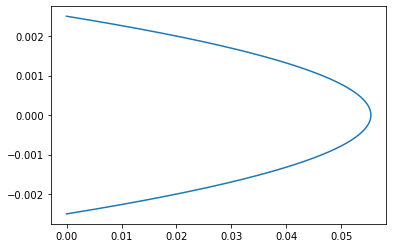

In [136]:
# Prescribed flow rate
system = reloadsystem()
# Q_des = np.pi * (system.y_end/2)**2 * blood_flow_rate
eps = 1e-3
error = 1
system.set_pressure_difference(pressure_difference)

velocity = system.simulate(mu)
Q = np.trapz(velocity, x=system.y)
factor = 0.95
#P = [system.pressure_difference, 2*system.pressure_difference]
switch = [0,0]

while error > eps:
# for i in range(1):
    if switch[-2] != switch[-1]:
        factor*=0.9
    if Q<Q_des:
        # system.pressure_difference = P[-1] + np.abs(P[-1]-P[-2])/2 * factor
        system.pressure_difference += system.pressure_difference * factor

        velocity = system.simulate(mu)
        Q = np.trapz(velocity, x=system.y)
        error = np.abs((Q-Q_des)/Q_des)
        switch.append(0)
        # P.append(system.pressure_difference)
    else:
        # system.pressure_difference = P[-1] - np.abs(P[-1]-P[-2])/2 * fac
        system.pressure_difference -= system.pressure_difference * factor
        velocity = system.simulate(mu)
        Q = np.trapz(velocity, x=system.y)
        error = np.abs((Q-Q_des)/Q_des)
        # P.append(system.pressure_difference)
        switch.append(1)
    if len(switch) == 300:
        print("Oh nyo, it's bwoken")
        break

velocity_laminar = velocity
mu_laminar = mu

print(len(switch))
plt.plot(velocity, system.y)
print(Q, Q_des)

In [137]:
# argument_type = None

# velocity_new = velocity_laminar

# # Then calculate the solution with Prandtl mixing length
# eps = 0.01
# error = 1
# i = 0

# # Looping till solution converges
# while error > eps:
#     velocity = velocity_new

#     # Calculate new effective viscosity
#     mu_Prandtl = system.calc_mu_Prandtl(velocity, argument_type)

#     # Calculate ensuing velocity
#     velocity_new = system.simulate(mu_Prandtl)

#     error = np.sum(np.abs((velocity_new - velocity) / velocity))
#     i+=1
#     print("iteration", i, "with error", error, end='\r')

#     if i > 2000:
#         print("Oh nyo, it's bwoken")
#         break

# velocity_turbulent = velocity_new
# mu_turbulent = mu_Prandtl

# plt.plot(velocity_laminar, system.y, label="laminar")
# plt.plot(velocity_turbulent, system.y, label="pml")
# plt.title("velocity with prandtl mixing length vs laminar")
# plt.xlabel('Velocity [m/s]')
# plt.ylabel('Channel height [m]')
# plt.legend()
# plt.show()

# # Check for log region
# plt.plot(system.y + system.y_end / 2, velocity_laminar)
# plt.plot(system.y + system.y_end / 2, velocity_turbulent)
# plt.xscale("log")

In [138]:
argument_type = "Driest"

velocity_new = velocity_laminar

# Then calculate the solution with Prandtl mixing length
eps = 0.01
error = 1
i = 0

# Looping till solution converges
while error > eps:
    velocity = velocity_new

    # Calculate new effective viscosity
    mu_Prandtl = system.calc_mu_Prandtl(velocity, argument_type)

    # Calculate ensuing velocity
    velocity_new = system.simulate(mu_Prandtl)

    error = np.sum(np.abs((velocity_new - velocity) / velocity))
    i+=1
    print("iteration", i, "with error", error, end='\r')

    if i > 2000:
        print("Oh nyo, it's bwoken")
        break

velocity_Driest = velocity_new
mu_Driest = mu_Prandtl

# plt.plot(velocity_laminar, system.y, label="laminar")
# plt.plot(velocity_Driest, system.y, label="driest")
# plt.plot(velocity_turbulent, system.y, label="pml")

# plt.title("velocity with prandtl mixing length vs laminar")
# plt.xlabel('Velocity [m/s]')
# plt.ylabel('Channel height [m]')
# plt.legend()
# plt.show()

# # Check for log region
# plt.plot(system.y + system.y_end / 2, velocity_laminar)
# plt.plot(system.y + system.y_end / 2, velocity_Driest)
# plt.xscale("log")

iteration 9 with error 1.5094724709253557e-06


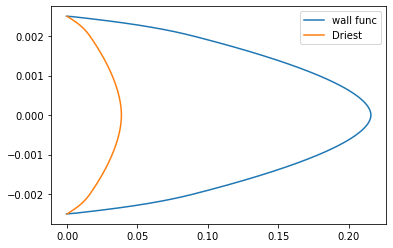

In [164]:
# Wall Function Constants 
velocity_new = velocity_turbulent
E = 9.8
kappa = 0.41
ks = 10 * system.nu_0

i = 0
error = 1
epsilon = 1e-5
while error > epsilon:
    velocity = velocity_new

    # Calculate the new y_plus
    tau_wall = velocity[1] / system.y_wall[1]
    u_tau = np.sqrt(tau_wall / system.rho)
    nu_0 = (mu_turbulent / system.rho)
    y_plus = system.y_wall * u_tau / nu_0

    # Calculate new wall roughness
    ks_plus = u_tau * ks / nu_0[1]
    wall_roughness = 32.6 / ks_plus

    
    # Add new nu for at wall
    nu_plus = np.zeros(system.Ny+2)
    mask = (y_plus < 11.25) * (y_plus > 0)
    nu_plus[mask] = nu_0[mask] * (y_plus[mask] * kappa / np.log(wall_roughness * y_plus[mask]) - 1)
    nu = nu_0 + nu_plus
    mu = nu * system.rho

    # Calculate new velocity
    velocity_new = system.simulate(mu)

    # Error difference in old and new velocity
    error = np.sum(np.abs((velocity_new - velocity) / velocity))
    i+=1
    # print("iteration", i, "with error", error, end='\r')

    if i > 200:
        print("Oh nyo, it's bwoken")
        break

velocity_wall_functions = velocity_new
mu_wall_functions = mu
print("iteration", i, "with error", error, end='\n')
plt.plot(velocity_new, system.y, label="wall func")
plt.plot(velocity_Driest, system.y, label="Driest")
plt.legend()
plt.show()

In [165]:
"""
# Add particles to the system
system = reloadsystem()
system.add_particles(rho_RBC, diameter_RBC, volume_fraction_RBC)



# calculate initial alpha of the particles
alpha_particles = system.calc_alpha(velocity_Driest, mu_Driest)

# Calculate volumetric plasma concentration
alpha_fluid = 1 - alpha_particles
velocity_new = velocity_Driest

# While loop to iterate of velocity
i = 0
error = 1
epsilon = 1e-3
while error > epsilon:
    velocity = velocity_new

    # Calculate new velocity
    velocity_new = system.simulate_with_particles(mu_Driest, alpha_fluid)

    # Error difference in old and new velocity
    error = np.sum(np.abs((velocity_new - velocity) / velocity))
    alpha_particles = system.calc_alpha(velocity_turbulent, mu_turbulent)

    # Calculate volumetric plasma concentration
    alpha_fluid = 1 - alpha_particles
    i+=1

    if i > 200:
        print("Oh nyo, it's bwoken")
        break


velocity_plasma = velocity_new
velocity_particle = system.solve_particle_velocity(alpha_particles, velocity_plasma, mu_turbulent)

# plt.plot(velocity_particle, system.y[1:-1],label="Particle")
# plt.plot(velocity_plasma[1:-1], system.y[1:-1], label="Plasma")
# # plt.xlim(-1e-9, 0)
# plt.legend()
# plt.show()
plt.figure(figsize=(6,3.5))
plt.plot(alpha_particles[alpha_particles != 0], system.y[alpha_particles != 0]*1e3)
plt.xlabel("Particle Concentration", fontsize=14)
plt.ylabel('Position [mm]', fontsize=14)
plt.tight_layout()
plt.savefig("Images/Concentration_particles.svg")
plt.show()
"""
print('help')

help


c:\Users\brent\Documents\comp_multphase_flow\functions.py:327: RuntimeWarning: divide by zero encountered in true_divide
  
c:\Users\brent\Documents\comp_multphase_flow\functions.py:327: RuntimeWarning: invalid value encountered in multiply
  


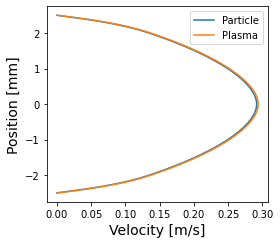

In [166]:
# Add particles to the system
system = reloadsystem()
volume_fraction_RBC = 0.2
rho_RBC = 1096
system.add_particles(rho_RBC, diameter_RBC, volume_fraction_RBC)

# calculate initial alpha of the particles
alpha_particles = system.calc_alpha(velocity_wall_functions, mu_wall_functions)

# Calculate volumetric plasma concentration
alpha_fluid = 1 - alpha_particles
velocity_new = velocity_wall_functions

# While loop to iterate of velocity
i = 0
error = 1
epsilon = 1e-3
while error > epsilon:
    velocity = velocity_new

    # Calculate new velocity
    velocity_new = system.simulate_with_particles(mu_wall_functions, alpha_fluid)

    # Error difference in old and new velocity
    error = np.sum(np.abs((velocity_new - velocity) / velocity))
    alpha_particles = system.calc_alpha(velocity_turbulent, mu_wall_functions)
    
    # Calculate volumetric plasma concentration
    alpha_fluid = 1 - alpha_particles
    i+=1

    if i > 200:
        print("Oh nyo, it's bwoken")
        break


velocity_plasma = velocity_new
velocity_particle = system.solve_particle_velocity(alpha_particles, velocity_plasma, mu_wall_functions)
plt.figure(figsize=(4,3.5))
plt.plot(velocity_particle, 1e3*system.y[1:-1],label="Particle")
plt.plot(velocity_plasma[1:-1], 1e3*system.y[1:-1], label="Plasma")
plt.xlabel('Velocity [m/s]', fontsize=14)
plt.ylabel('Position [mm]', fontsize=14)
plt.legend(fontsize=10)
plt.tight_layout()
# plt.savefig("Images/Particle_Velocity_045_zoomin.svg")
plt.show()

In [167]:
# vel_part_driest = velocity_particle
# vel_fluid_driest = velocity_plasma

# vel_part_wall_10 = velocity_particle
# vel_fluid_wall_10 = velocity_plasma
# ks_plus_10 = ks_plus

# vel_part_wall_40 = velocity_particle
# vel_fluid_wall_40 = velocity_plasma
# ks_plus_40 = ks_plus

# vel_part_wall_75 = velocity_particle
# vel_fluid_wall_75 = velocity_plasma
# ks_plus_75 = ks_plus



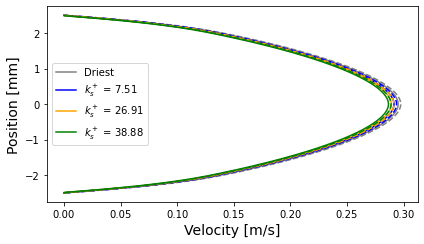

0.20865996839657777
0.2951918290084985
0.20064829100292803
0.2866291593829451
0.20550490667190807
0.2915085615432487


In [202]:
plt.figure(figsize=(6,3.5))
plt.plot(vel_part_driest, 1e3*system.y[1:-1],label="Driest", color='grey')
plt.plot(vel_fluid_driest[1:-1], 1e3*system.y[1:-1], linestyle='dashed', color='grey')
plt.plot(vel_part_wall_10, 1e3*system.y[1:-1],label=r'$k_s^+$ = {}'.format(round(ks_plus_10,2)), color='blue')
plt.plot(vel_fluid_wall_10[1:-1], 1e3*system.y[1:-1], linestyle='dashed', color='blue')
plt.plot(vel_part_wall_40, 1e3*system.y[1:-1], label=r'$k_s^+$ = {}'.format(round(ks_plus_40,2)), color='orange')
plt.plot(vel_fluid_wall_40[1:-1], 1e3*system.y[1:-1], linestyle='dashed', color='orange')
plt.plot(vel_part_wall_75, 1e3*system.y[1:-1],label=r'$k_s^+$ = {}'.format(round(ks_plus_75,2)), color='green')
plt.plot(vel_fluid_wall_75[1:-1], 1e3*system.y[1:-1], linestyle='dashed', color='green')
plt.xlabel('Velocity [m/s]', fontsize=14)
# plt.xlim(0.25,0.3)
# plt.ylim(-1, 1)
plt.ylabel('Position [mm]', fontsize=14)
plt.legend(fontsize=10)
plt.tight_layout()
plt.savefig("Images/wall_functions_effectless_zoomin.svg")
plt.show()

print(np.mean(vel_part_driest))
print(np.max(vel_part_driest))
print(np.mean(vel_part_wall_75))
print(np.max(vel_part_wall_75))

print(np.mean(vel_part_wall_10))
print(np.max(vel_part_wall_10))

# velocity_particle_1100 = velocity_particle
# velocity_plasma_1100 = velocity_plasma
# velocity_particle_1500 = velocity_particle
# velocity_plasma_1500 = velocity_plasma
# velocity_particle_2500 = velocity_particle
# velocity_plasma_2500 = velocity_plasma

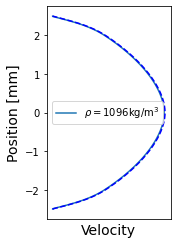

In [119]:
# plt.figure(figsize=(2.57,3.5))
# plt.plot(velocity_particle_1100, system.y[1:-1]*1e3, label=r"$\rho = 1096 \mathrm{kg/m^3}$")
# # plt.plot(velocity_particle_1500, system.y[1:-1]*1e3, label=r"$\rho = 1500 \mathrm{kg/m^3}$", color='orange')
# # plt.plot(velocity_particle_2500, system.y[1:-1]*1e3, label=r"$\rho = 2500 \mathrm{kg/m^3}$", color="green")
# plt.plot(velocity_plasma_1100, system.y*1e3, color='blue', linestyle='dashed')
# # plt.plot(velocity_plasma_1500, system.y*1e3, color='orange', linestyle='dashed')
# # plt.plot(velocity_plasma_2500, system.y*1e3, color='green', linestyle='dashed')
# plt.xticks(ticks=[])
# # plt.yticks(ticks=[-2,-1,-0,1,2], labels=[" "," "," "," "," "])
# plt.xlabel('Velocity', fontsize=14)
# plt.ylabel('Position [mm]', fontsize=14)
# plt.legend(fontsize=10, loc="center left")
# plt.tight_layout()
# plt.savefig("Images/Particles_1100.svg")
# plt.legend()
# plt.show()


<ipython-input-187-5bcf4c23c1bf>:28: RuntimeWarning: divide by zero encountered in double_scalars
  wall_roughness = 32.6 / ks_plus
C:\Users\brent\AppData\Roaming\Python\Python38\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:206: MatrixRankWarning: Matrix is exactly singular
  warn("Matrix is exactly singular", MatrixRankWarning)
c:\Users\brent\Documents\comp_multphase_flow\functions.py:219: RuntimeWarning: divide by zero encountered in true_divide
  T_part = self.rho_particle * self.particle_D**2 / (18 * mu_edges)
c:\Users\brent\Documents\comp_multphase_flow\functions.py:303: RuntimeWarning: divide by zero encountered in true_divide
  
c:\Users\brent\Documents\comp_multphase_flow\functions.py:327: RuntimeWarning: divide by zero encountered in true_divide
  
c:\Users\brent\Documents\comp_multphase_flow\functions.py:327: RuntimeWarning: invalid value encountered in multiply
  


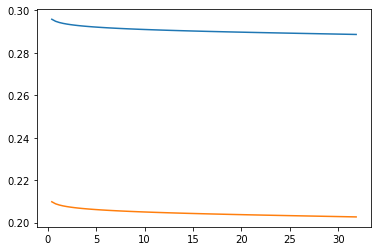

[       nan 0.20984246 0.2088825  0.20831186 0.20790215 0.20758125
 0.20731683 0.20709157 0.20689509 0.20672067 0.20656371 0.20642092
 0.20628986 0.20616867 0.20605591 0.20595043 0.20585131 0.20575778
 0.20566921 0.20558506 0.20550491 0.20542835 0.20535506 0.20528475
 0.20521717 0.2051521  0.20508934 0.20502873 0.2049701  0.20491333
 0.20485828 0.20480484 0.20475292 0.20470241 0.20465324 0.20460533
 0.2045586  0.20451299 0.20446845 0.20442492 0.20438233 0.20434066
 0.20429986 0.20425987 0.20422067 0.20418222 0.20414449 0.20410744
 0.20407105 0.20403528 0.20400012 0.20396553 0.2039315  0.203898
 0.20386501 0.20383252 0.20380049 0.20376893 0.2037378  0.2037071
 0.20367681 0.20364691 0.20361738 0.20358823 0.20355943 0.20353098
 0.20350285 0.20347505 0.20344755 0.20342035 0.20339345 0.20336682
 0.20334046 0.20331437 0.20328853 0.20326294 0.20323758 0.20321246
 0.20318756 0.20316287 0.20313839 0.20311412 0.20309004 0.20306615
 0.20304245 0.20301893 0.20299557 0.20297238 0.20294936 0.2029264

In [187]:
ks_array = np.arange(0, 50, 0.5)
max_array = np.zeros(len(ks_array))
mean_array = np.zeros(len(ks_array))
ks_plus_array = np.zeros(len(ks_array))


for ii in range(len(ks_array)):
    # Wall Function Constants 
    velocity_new = velocity_turbulent
    E = 9.8
    kappa = 0.41
    ks = ks_array[ii] * system.nu_0

    i = 0
    error = 1
    epsilon = 1e-5
    while error > epsilon:
        velocity = velocity_new

        # Calculate the new y_plus
        tau_wall = velocity[1] / system.y_wall[1]
        u_tau = np.sqrt(tau_wall / system.rho)
        nu_0 = (mu_turbulent / system.rho)
        y_plus = system.y_wall * u_tau / nu_0

        # Calculate new wall roughness
        ks_plus = u_tau * ks / nu_0[1]
        wall_roughness = 32.6 / ks_plus

        
        # Add new nu for at wall
        nu_plus = np.zeros(system.Ny+2)
        mask = (y_plus < 11.25) * (y_plus > 0)
        nu_plus[mask] = nu_0[mask] * (y_plus[mask] * kappa / np.log(wall_roughness * y_plus[mask]) - 1)
        nu = nu_0 + nu_plus
        mu = nu * system.rho

        # Calculate new velocity
        velocity_new = system.simulate(mu)

        # Error difference in old and new velocity
        error = np.sum(np.abs((velocity_new - velocity) / velocity))
        i+=1
        # print("iteration", i, "with error", error, end='\r')

        if i > 200:
            print("Oh nyo, it's bwoken")
            break

    velocity_wall_functions = velocity_new
    mu_wall_functions = mu
    # print("iteration", i, "with error", error, end='\n')

    # Add particles to the system
    system = reloadsystem()
    volume_fraction_RBC = 0.2
    rho_RBC = 1096
    system.add_particles(rho_RBC, diameter_RBC, volume_fraction_RBC)

    # calculate initial alpha of the particles
    alpha_particles = system.calc_alpha(velocity_wall_functions, mu_wall_functions)

    # Calculate volumetric plasma concentration
    alpha_fluid = 1 - alpha_particles
    velocity_new = velocity_wall_functions

    # While loop to iterate of velocity
    i = 0
    error = 1
    epsilon = 1e-3
    while error > epsilon:
        velocity = velocity_new

        # Calculate new velocity
        velocity_new = system.simulate_with_particles(mu_wall_functions, alpha_fluid)

        # Error difference in old and new velocity
        error = np.sum(np.abs((velocity_new - velocity) / velocity))
        alpha_particles = system.calc_alpha(velocity_turbulent, mu_wall_functions)
        
        # Calculate volumetric plasma concentration
        alpha_fluid = 1 - alpha_particles
        i+=1

        if i > 200:
            print("Oh nyo, it's bwoken")
            break


    velocity_plasma = velocity_new
    velocity_particle = system.solve_particle_velocity(alpha_particles, velocity_plasma, mu_wall_functions)
    max_array[ii] = np.max(velocity_particle)
    mean_array[ii] = np.mean(velocity_particle)
    ks_plus_array[ii] = ks_plus

plt.figure()
plt.plot(ks_plus_array,max_array)
plt.plot(ks_plus_array,mean_array)
plt.show()

print(mean_array)

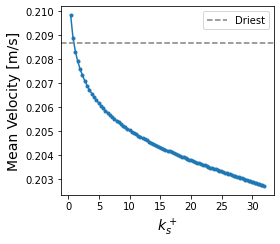

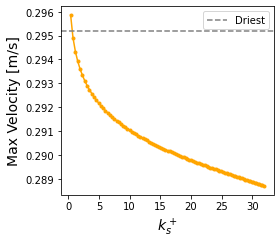

In [197]:
plt.figure(figsize=(4,3.5))
plt.plot(ks_plus_array,mean_array,'.-')
plt.axhline(np.mean(vel_part_driest), color='grey', linestyle='dashed', label='Driest')
plt.xlabel(r"$k_s^+$", fontsize=14)
plt.ylabel("Mean Velocity [m/s]", fontsize=14)
plt.legend(fontsize=10)
plt.tight_layout()
plt.savefig("Images/Ks_mean.svg")
plt.show()


plt.figure(figsize=(4,3.5))
plt.plot(ks_plus_array,max_array,'.-', color='orange')
plt.axhline(np.max(vel_part_driest), color='grey', linestyle='dashed', label='Driest')
plt.xlabel(r"$k_s^+$", fontsize=14)
plt.ylabel("Max Velocity [m/s]", fontsize=14)
plt.legend(fontsize=10)
plt.tight_layout()
plt.savefig("Images/Ks_max.svg")
plt.show()


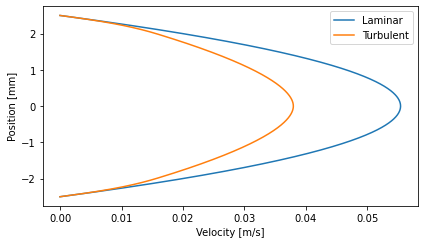

In [206]:
rho_plasma = 1003 #  kg/m3
mu_plasma = 1e-3 # kg/ms

rho_RBC = 1096 # kg/m3
diameter_RBC = 8e-6 # m
volume_fraction_RBC = 0.2

y_end = 5e-3 # m
Ny = 1000
angle = np.pi / 4

boundary_condition = [1, 1] 
blood_flow_rate = 20e-3 # m/s  # moet gecheckt worden
Q_des = 185*1e-6 #m3/s total bloodflow
pressure_difference = 1e-3
pressure_boundary = np.array([1, 1])*1e-3
system = mf.Multiflow(Ny, y_end, rho_plasma, pressure_difference,
                      pressure_boundary, boundary_condition, mu_plasma, angle)
mu = system.calc_mu(mu_plasma)


def reloadsystem():
    importlib.reload(mf)
    system = mf.Multiflow(Ny, y_end, rho_plasma, pressure_difference,
                      pressure_boundary, boundary_condition, mu_plasma, angle)
    return system


# Prescribed flow rate
system = reloadsystem()
# Q_des = np.pi * (system.y_end/2)**2 * blood_flow_rate
eps = 1e-3
error = 1
system.set_pressure_difference(pressure_difference)

velocity = system.simulate(mu)
Q = np.trapz(velocity, x=system.y)
factor = 0.95
#P = [system.pressure_difference, 2*system.pressure_difference]
switch = [0,0]

while error > eps:
# for i in range(1):
    if switch[-2] != switch[-1]:
        factor*=0.9
    if Q<Q_des:
        # system.pressure_difference = P[-1] + np.abs(P[-1]-P[-2])/2 * factor
        system.pressure_difference += system.pressure_difference * factor

        velocity = system.simulate(mu)
        Q = np.trapz(velocity, x=system.y)
        error = np.abs((Q-Q_des)/Q_des)
        switch.append(0)
        # P.append(system.pressure_difference)
    else:
        # system.pressure_difference = P[-1] - np.abs(P[-1]-P[-2])/2 * fac
        system.pressure_difference -= system.pressure_difference * factor
        velocity = system.simulate(mu)
        Q = np.trapz(velocity, x=system.y)
        error = np.abs((Q-Q_des)/Q_des)
        # P.append(system.pressure_difference)
        switch.append(1)
    if len(switch) == 300:
        print("Oh nyo, it's bwoken")
        break

velocity_laminar = velocity
mu_laminar = mu

argument_type = None

velocity_new = velocity_laminar

# Then calculate the solution with Prandtl mixing length
eps = 0.01
error = 1
i = 0

# Looping till solution converges
while error > eps:
    velocity = velocity_new

    # Calculate new effective viscosity
    mu_Prandtl = system.calc_mu_Prandtl(velocity, argument_type)

    # Calculate ensuing velocity
    velocity_new = system.simulate(mu_Prandtl)

    error = np.sum(np.abs((velocity_new - velocity) / velocity))
    i+=1
    print("iteration", i, "with error", error, end='\r')

    if i > 2000:
        print("Oh nyo, it's bwoken")
        break

velocity_turbulent = velocity_new
mu_turbulent = mu_Prandtl

plt.figure(figsize=(6,3.5))
plt.plot(velocity_laminar, system.y*1e3, label="Laminar")
plt.plot(velocity_turbulent, system.y*1e3, label="Turbulent")
# plt.title("velocity with prandtl mixing length vs laminar")
plt.xlabel('Velocity [m/s]')
plt.ylabel('Position [mm]')
plt.legend()
plt.tight_layout()
plt.savefig("Images/Turbulent_vs_Laminar.svg")
plt.show()